In [133]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/penugasan-oprec-dsai-2024/sample_submission.csv
/kaggle/input/penugasan-oprec-dsai-2024/Train.csv
/kaggle/input/penugasan-oprec-dsai-2024/Test.csv


# **Library**

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# **Data Understanding**

In [135]:
tugas_df = pd.read_csv('/kaggle/input/penugasan-oprec-dsai-2024/Train.csv')

In [273]:
tugas_df

,id,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary,z_score
17,-0.962804,0.00,EN,FT,Data Analyst,USD,US,0.0,US,M,92900.0,-0.778225
18,-0.962718,0.00,SE,FT,Analytics Engineer,USD,US,0.0,US,M,175000.0,0.340035
20,-0.962631,0.00,SE,FT,Data Engineer,USD,US,0.0,US,M,330985.0,4.766765
22,-0.962501,0.00,SE,FT,Data Analyst,USD,US,0.0,US,M,140000.0,-0.136689
23,-0.962414,0.00,SE,FT,Data Scientist,USD,US,0.0,US,L,247600.0,1.328899
...,...,...,...,...,...,...,...,...,...,...,...,...
35041,1.198926,-0.25,MI,FT,Data Analyst,USD,US,1.0,US,L,99134.0,-0.693313
35046,1.199229,0.00,SE,FT,Research Engineer,USD,US,0.0,US,L,129280.0,-0.282703
35048,1.199316,-0.50,EX,FT,Software Engineer,USD,PL,1.0,PL,M,59202.0,-1.237215
35053,1.199576,-0.50,SE,FT,Data Engineer,USD,US,1.0,US,M,73035.0,-1.048800


In [137]:
test_df = pd.read_csv('/kaggle/input/penugasan-oprec-dsai-2024/Test.csv')

In [138]:
tugas_df.columns

Index(['id', 'work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_currency', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size', 'salary'],
      dtype='object')

In [139]:
tugas_df.describe()

,id,work_year,remote_ratio,salary
count,35078.000000,28062.000000,28062.000000,35078.000000
mean,23213.081476,2023.686373,0.482646,150517.661811
std,14114.394161,0.698085,0.855120,72965.037566
min,0.000000,2020.000000,0.000000,15000.000000
25%,11158.750000,2024.000000,0.000000,99070.750000
50%,22410.500000,2024.000000,0.000000,140000.000000
75%,34760.750000,2024.000000,0.000000,191920.500000
max,49999.000000,2024.000000,2.000000,800000.000000


# **Missing Value**

In [140]:
tugas_df.isnull().any

<bound method DataFrame.any of           id  work_year  experience_level  employment_type  job_title  \
0      False      False              True            False      False   
1      False      False             False            False      False   
2      False      False              True            False      False   
3      False      False              True             True      False   
4      False      False             False            False      False   
...      ...        ...               ...              ...        ...   
35073  False      False             False             True      False   
35074  False       True             False             True      False   
35075  False      False              True            False      False   
35076  False       True             False            False      False   
35077  False      False             False            False      False   

       salary_currency  employee_residence  remote_ratio  company_location  \
0             

In [141]:
tugas_df.isna().any()

id                    False
work_year              True
experience_level       True
employment_type        True
job_title             False
salary_currency       False
employee_residence     True
remote_ratio           True
company_location       True
company_size           True
salary                False
dtype: bool

Tidak ada missing data

In [142]:
print(tugas_df.isnull().sum())

id                       0
work_year             7016
experience_level      7016
employment_type       7016
job_title                0
salary_currency          0
employee_residence    7016
remote_ratio          7016
company_location      7016
company_size          7016
salary                   0
dtype: int64


In [143]:
missing_percentage = tugas_df.isnull().mean() * 100
print(missing_percentage[missing_percentage > 0]) 

work_year             20.00114
experience_level      20.00114
employment_type       20.00114
employee_residence    20.00114
remote_ratio          20.00114
company_location      20.00114
company_size          20.00114
dtype: float64


In [144]:
tugas_df.dropna(inplace=True)

# **Data Duplicate**

In [145]:
tugas_df.duplicated().value_counts()

False    7277
Name: count, dtype: int64

Tidak ada data duplicate

# **Outlier**

In [146]:
label_encoder = LabelEncoder()
tugas_df['work_year'] = label_encoder.fit_transform(tugas_df['work_year'])
tugas_df

,id,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary
17,24,4,EN,FT,Data Analyst,USD,US,0.0,US,M,92900
18,26,4,SE,FT,Analytics Engineer,USD,US,0.0,US,M,175000
20,28,4,SE,FT,Data Engineer,USD,US,0.0,US,M,500000
22,31,4,SE,FT,Data Analyst,USD,US,0.0,US,M,140000
23,33,4,SE,FT,Data Scientist,USD,US,0.0,US,L,247600
...,...,...,...,...,...,...,...,...,...,...,...
35041,49947,3,MI,FT,Data Analyst,USD,US,2.0,US,L,99134
35046,49954,4,SE,FT,Research Engineer,USD,US,0.0,US,L,129280
35048,49956,2,EX,FT,Software Engineer,USD,PL,2.0,PL,M,59202
35053,49962,2,SE,FT,Data Engineer,USD,US,2.0,US,M,73035


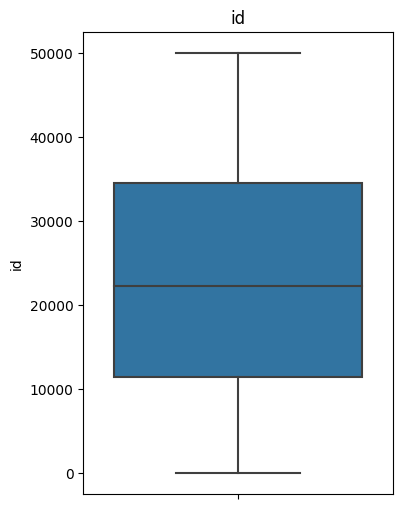

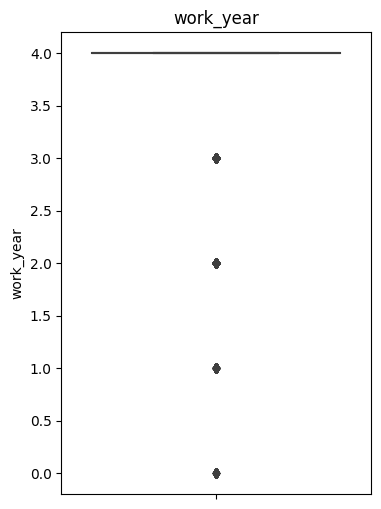

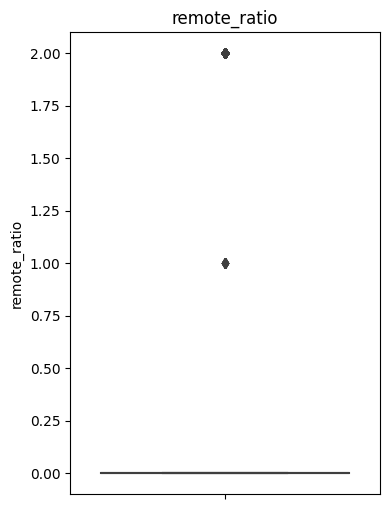

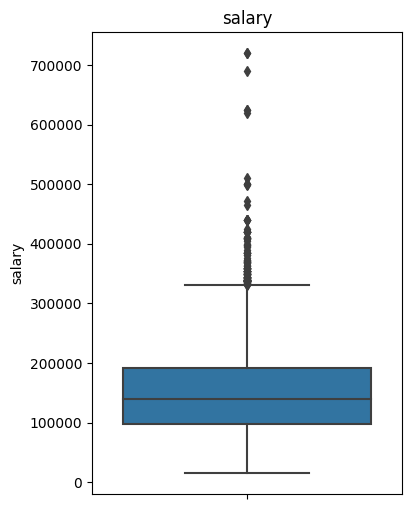

In [147]:
numeric_cols = tugas_df.select_dtypes(include=['number']).columns
for column in numeric_cols:
    plt.figure(figsize=(4, 6))
    sns.boxplot(data=tugas_df, y=column)
    plt.title(column)
    plt.show()


# **Data Cleaning**

In [148]:
from scipy.stats import zscore
tugas_df['z_score'] = zscore(tugas_df['salary'])

tugas_df_cleaned = tugas_df[(tugas_df['z_score'] <= 200000) & (tugas_df['z_score'] >= -200000)]
tugas_df_cleaned = tugas_df_cleaned.drop(columns=['z_score'])

print("Data setelah outlier dihapus:", tugas_df_cleaned.shape)

Data setelah outlier dihapus: (7277, 11)


<function matplotlib.pyplot.show(close=None, block=None)>

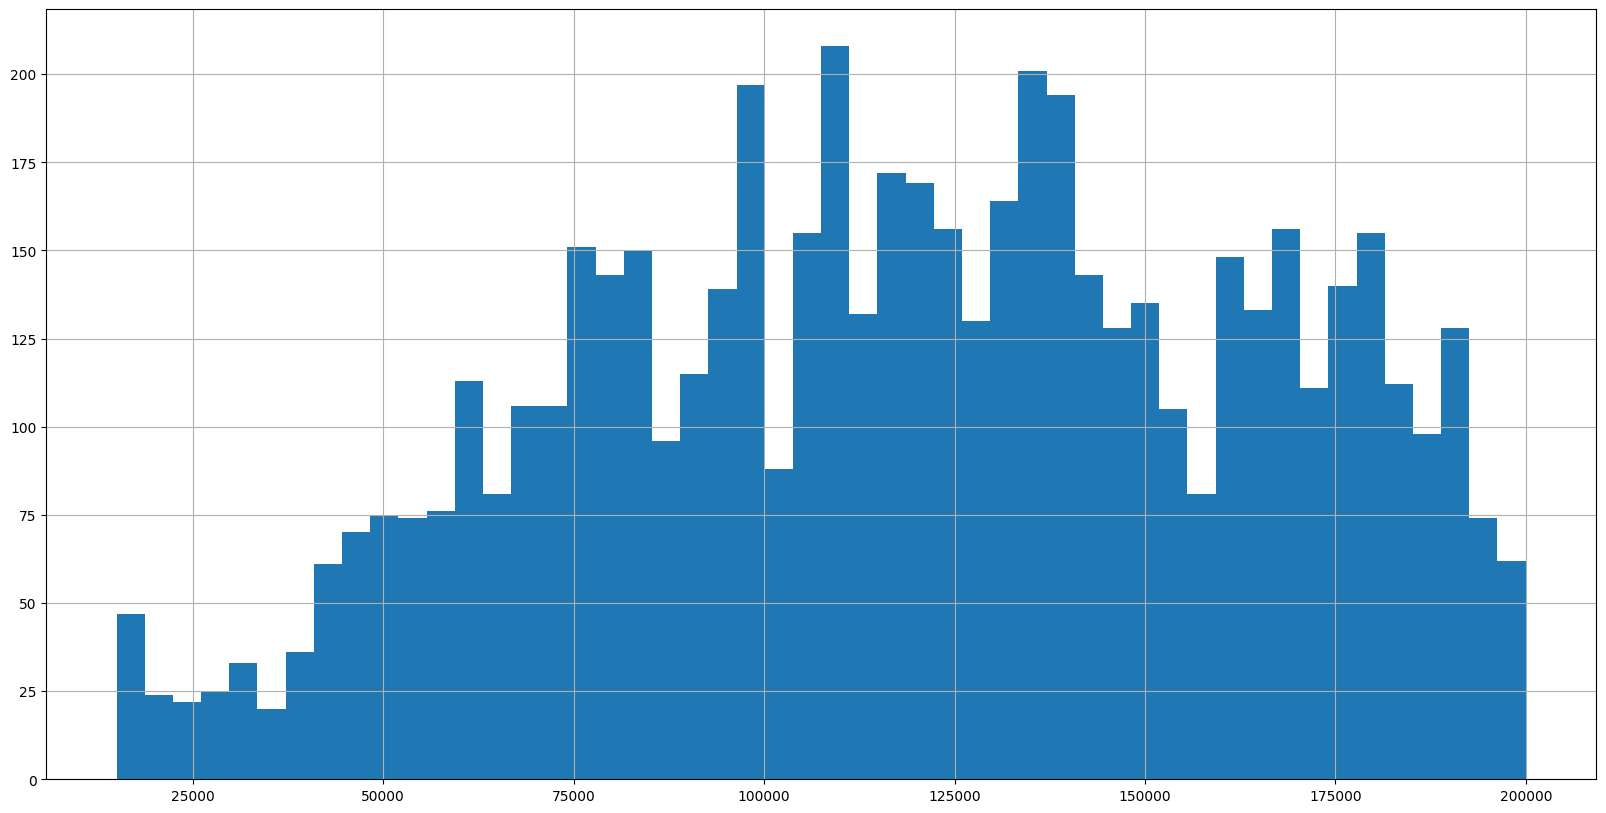

In [149]:
tugas_df_filtered = tugas_df[tugas_df['salary'] < 200000]
tugas_df_filtered['salary'].hist(figsize=(20,10), bins = 50)
plt.show

# **Categorical Encoding**

In [150]:
categorical_columns = ['experience_level', 'employment_type', 'employee_residence', 'company_size']
data_encoded = pd.get_dummies(tugas_df, columns=categorical_columns, drop_first=True)
data_encoded.head()

,id,work_year,job_title,salary_currency,remote_ratio,company_location,salary,z_score,experience_level_EX,experience_level_MI,...,employee_residence_SI,employee_residence_SK,employee_residence_TH,employee_residence_TR,employee_residence_UA,employee_residence_US,employee_residence_VN,employee_residence_ZA,company_size_M,company_size_S
17,24,4,Data Analyst,USD,0.0,US,92900,-0.778225,False,False,...,False,False,False,False,False,True,False,False,True,False
18,26,4,Analytics Engineer,USD,0.0,US,175000,0.340035,False,False,...,False,False,False,False,False,True,False,False,True,False
20,28,4,Data Engineer,USD,0.0,US,500000,4.766765,False,False,...,False,False,False,False,False,True,False,False,True,False
22,31,4,Data Analyst,USD,0.0,US,140000,-0.136689,False,False,...,False,False,False,False,False,True,False,False,True,False
23,33,4,Data Scientist,USD,0.0,US,247600,1.328899,False,False,...,False,False,False,False,False,True,False,False,False,False


In [151]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols='work_year',
                          return_df=True,
                          use_cat_names=True)
encoded_cols = encoder.fit_transform(tugas_df['work_year'])

encoded_cols = encoder.transform(test_df['work_year'])

In [152]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols='experience_level',
                          return_df=True,
                          use_cat_names=True)
encoded_cols = encoder.fit_transform(tugas_df['experience_level'])

encoded_test = encoder.transform(test_df['experience_level'])

In [153]:
target_encoding_columns = ['salary_currency', 'company_location']

for col in target_encoding_columns:
    target_mean = tugas_df.groupby(col)['salary'].mean()
    test_df[col + '_encoded'] = test_df[col].map(target_mean)
    
test_df.drop(columns=target_encoding_columns, inplace=True)
test_df.head()


,id,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_size,salary_currency_encoded,company_location_encoded
0,0,2024,SE,CT,Engineer,US,0,M,152183.385119,161421.073995
1,1,2023,MI,FT,Data Engineer,US,0,M,152183.385119,161421.073995
2,2,2024,SE,FT,Engineer,US,0,M,152183.385119,161421.073995
3,3,2024,SE,FT,Software Engineer,US,0,M,152183.385119,161421.073995
4,4,2024,MI,FT,Software Engineer,US,0,M,152183.385119,161421.073995


Untuk bagian gaji, kita pakaikan target encoding karena kita akan menghitung rata-rata gaji untuk memprediksikan total gaji per tahun.

# **Explolatory Data Analysis (EDA)**

In [154]:
tugas_df['salary'].sort_values()

32993     15000
34434     15000
34422     15000
34271     15000
34259     15000
          ...  
18102    625000
9150     625000
21172    690000
7523     720000
9831     720000
Name: salary, Length: 7277, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

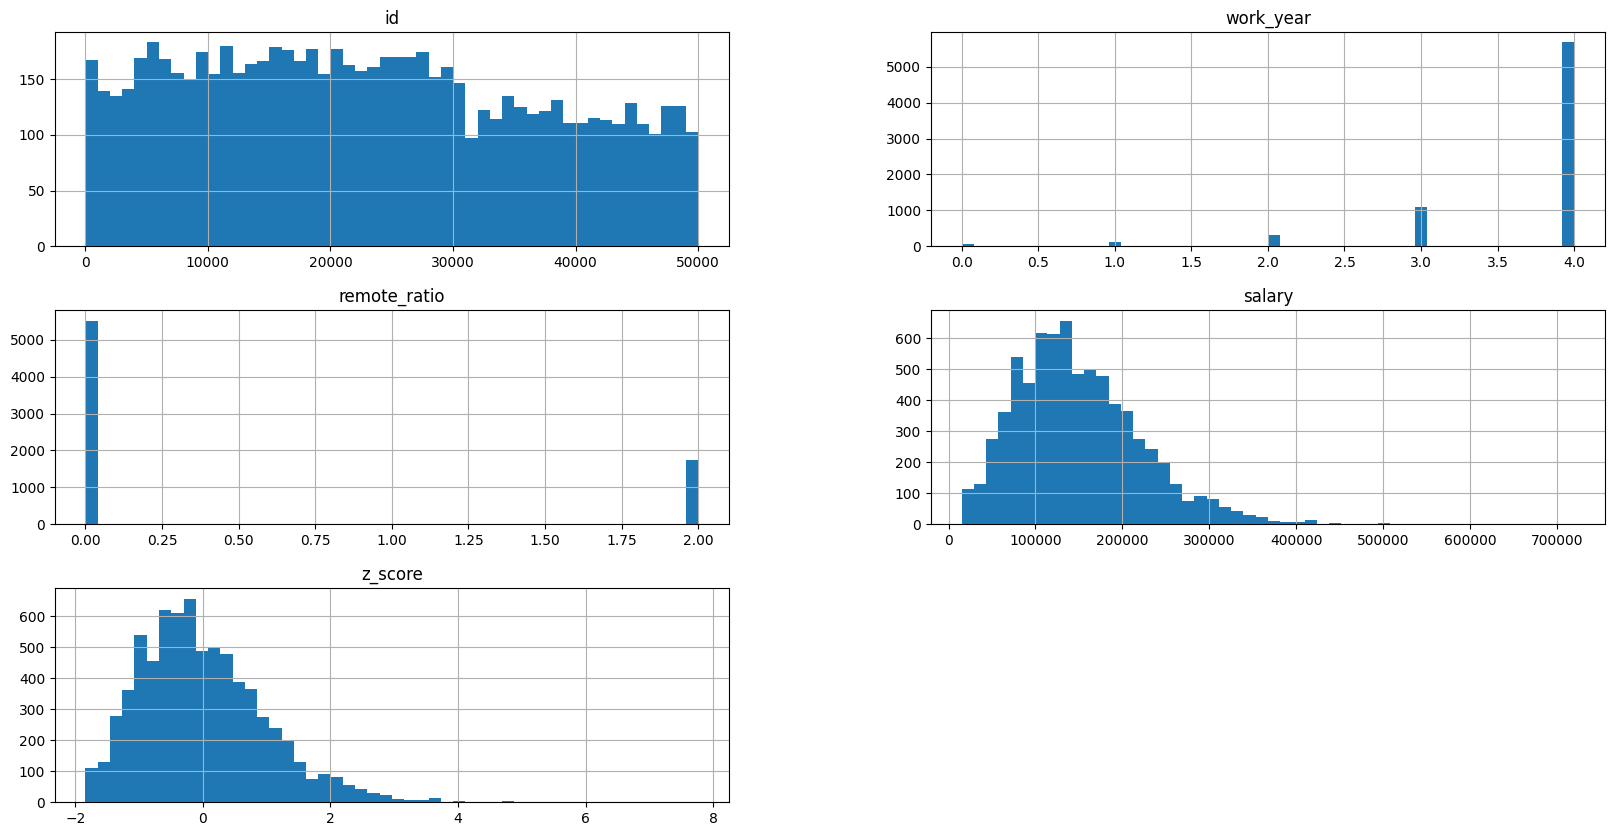

In [155]:
tugas_df.hist(figsize=(20,10), bins = 50)
plt.show

# Analisis grafik histogram :

>  1. id

Histogram menunjukkan distribusi yang cukup seragam dengan sedikit puncak di sekitar bagian tengah. Hal ini menunjukkan bahwa nilai id didistribusikan secara merata di seluruh kumpulan data. Kolom id mewakili pengenal unik untuk setiap titik data, dan distribusi yang seragam menunjukkan bahwa titik-titik data tidak mengelompok dalam rentang tertentu.

> 2. work_year

Nilai histogram sangat terfokus pada satu puncak menonjol (4). Hal ini mengindikasikan bahwa sebagian besar titik data dalam set data berasal dari jangka waktu tertentu. Tahun-tahun kerja yang lebih awal memiliki entri yang sangat sedikit. Mungkin ada peristiwa atau tren signifikan yang memengaruhi pengumpulan data pada tahun tersebut.

> 3. remote_ratio

Data menunjukkan distribusi bimodal dengan dua puncak yang berbeda, satu puncak berpusat di 0 (sepenuhnya bekerja jarak jauh), dan puncak lainnya di 2 (tidak ada pekerjaan jarak jauh). Sangat sedikit entri yang ada untuk pekerjaan jarak jauh parsial. 

> 4. salary
   
Penyebaran nilai histogram condong miring ke kanan dengan sebagian besar gaji terfokus kisaran yang lebih rendah (<200.000), sementara sebagian kecil individu memiliki gaji yang lebih tinggi  (<=700.000). Hal seperti ini lumrah dalam distribusi gaji, yang mencerminkan distribusi kekayaan yang tidak merata.


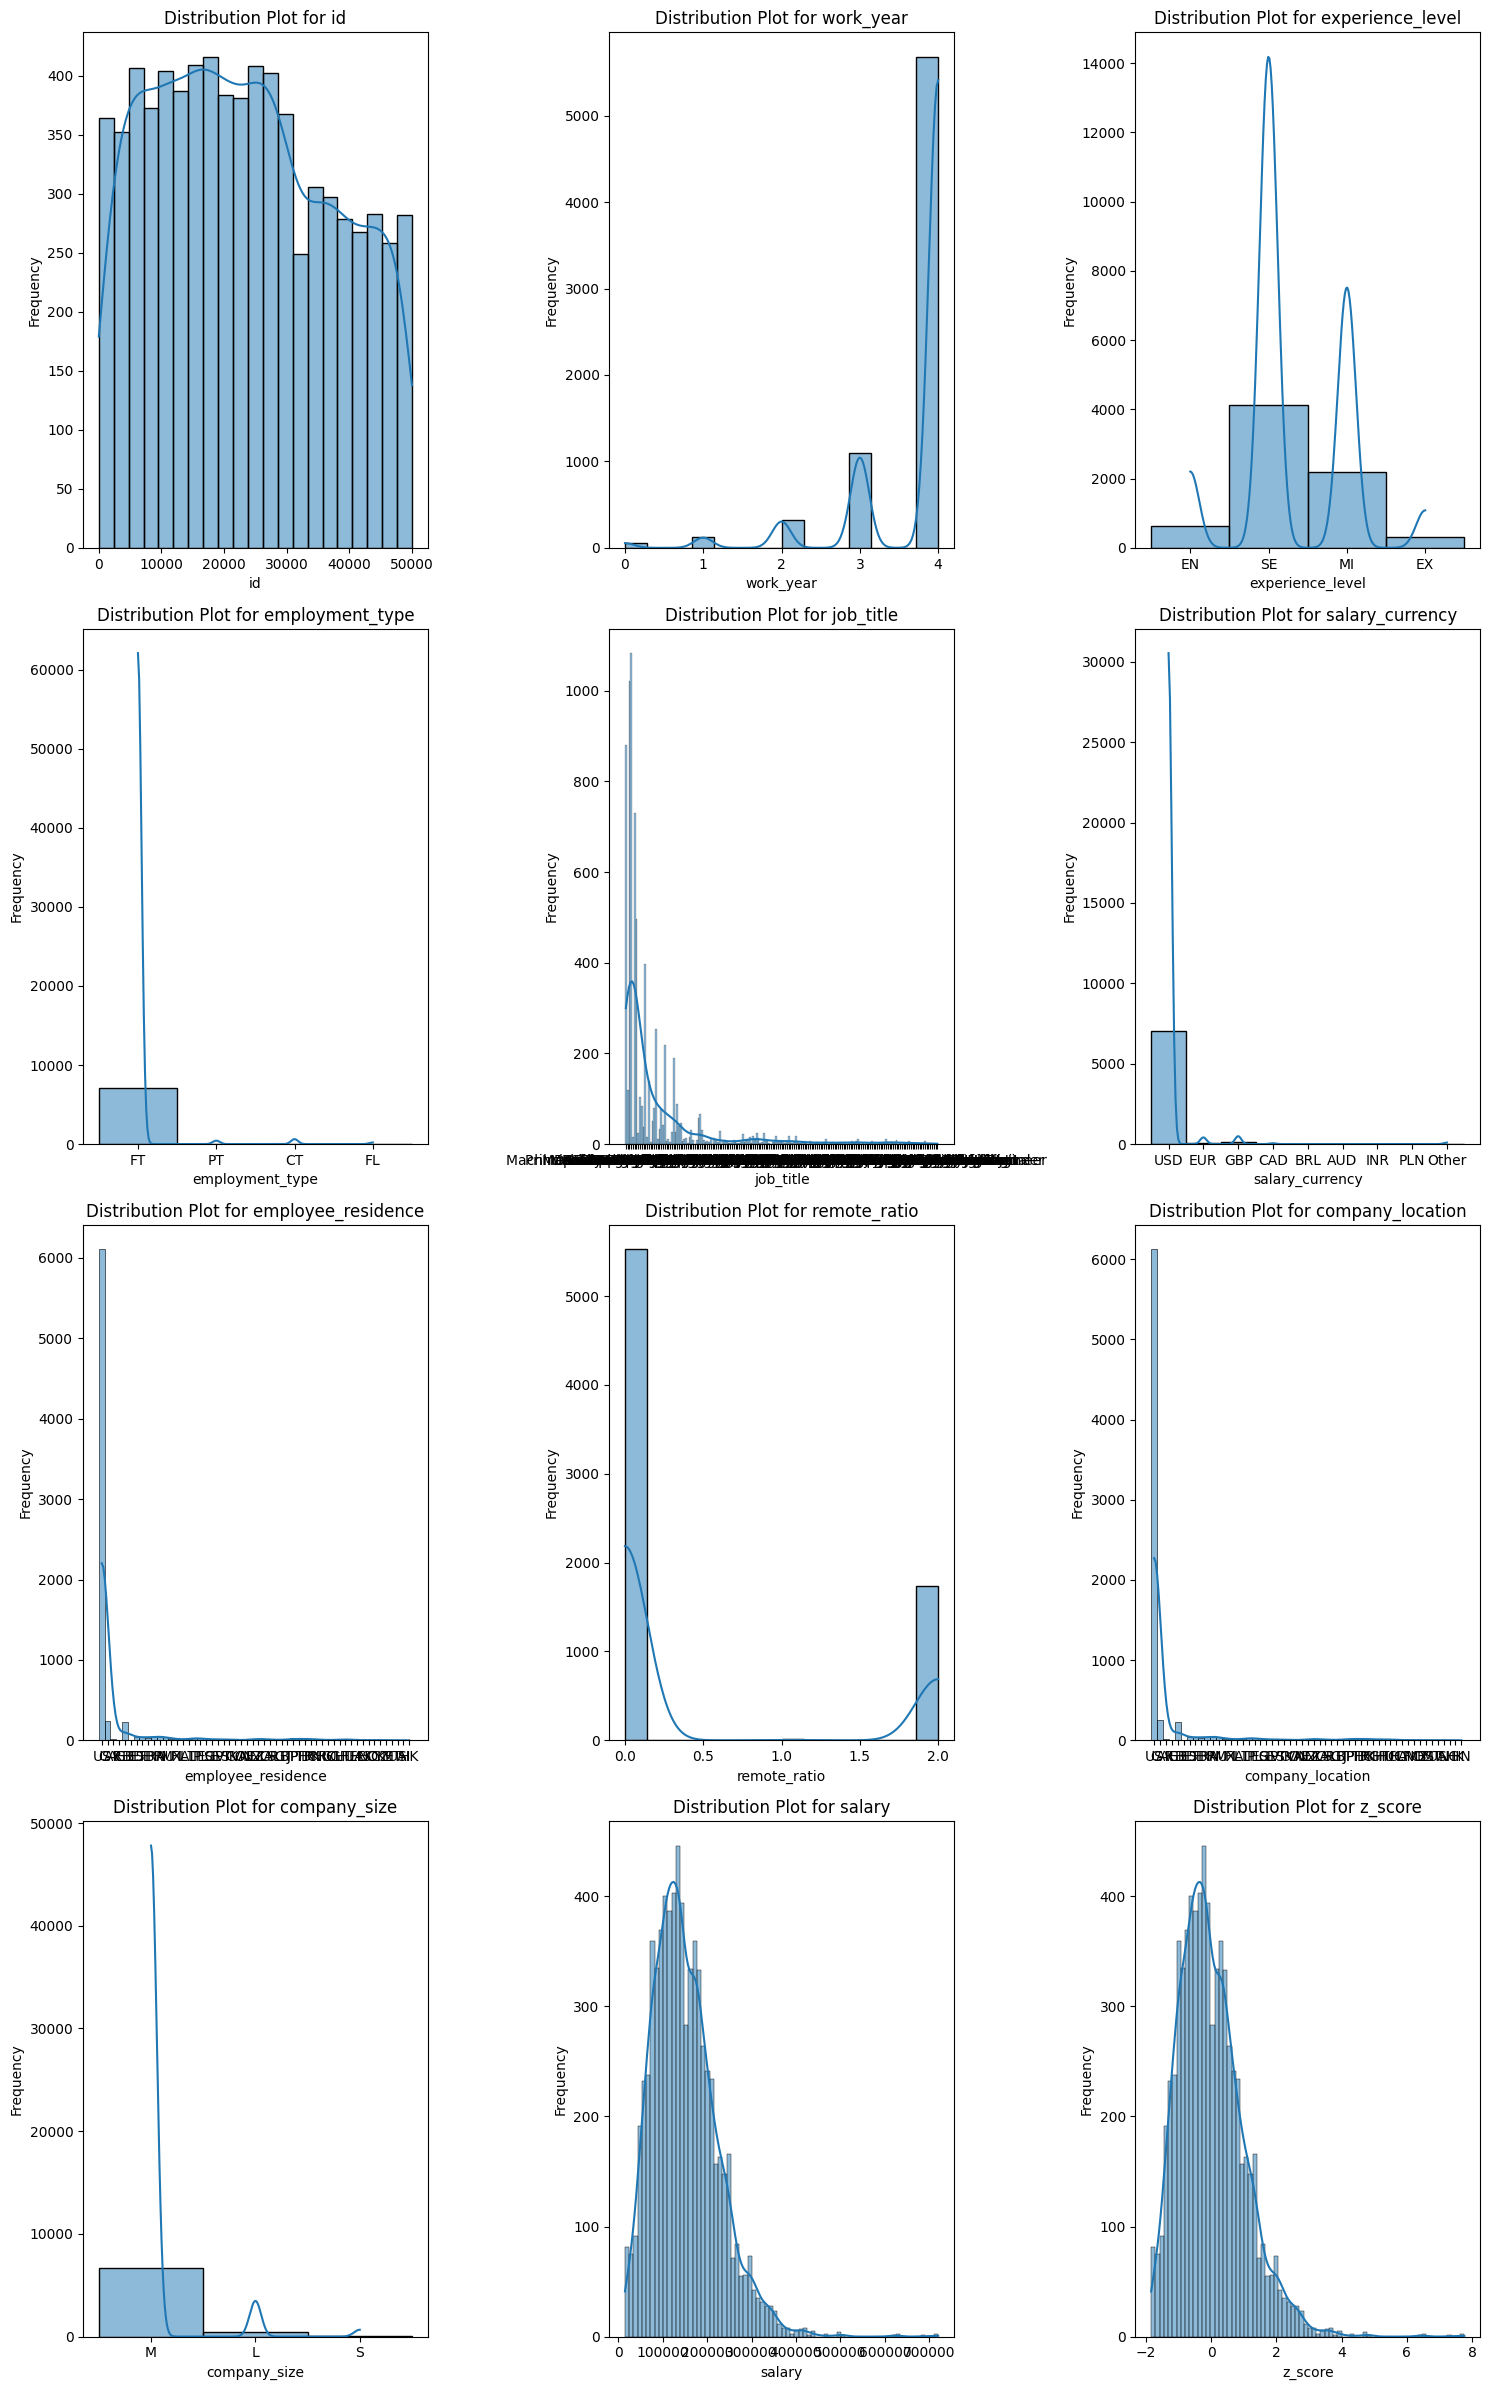

In [156]:
n_cols = 3  
n_rows = (len(tugas_df.columns) + n_cols - 1) // n_cols  

plt.figure(figsize=(5 * n_cols, 6 * n_rows))

for i, column in enumerate(tugas_df.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(tugas_df[column], kde=True)
    plt.title(f'Distribution Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Analisis Plot Distribusi:

> 1. id

    Nilai id relatif terdistribusi secara merata, dengan sedikit variasi dalam frekuensi, pusat distribusi berada di sekitar tengah-tengah. Frekuensi memuncak pada kisaran tengah dan menurun dekat bagian tepi. Penyebaran data cukup luas, mencakup rentang nilai besar. Tidak menunjukkan banyak variabilitas untuk dieksplorasi lebih lanjut.

> 2. work_year

    Distribusi sangat condong ke arah tahun terbaru, dengan ekor yang panjang ke arah nilai yang lebih tinggi serta puncak tajam pada nilai maksimum. Terdapat representasi minimal untuk tahun-tahun sebelumnya. Hal ini menunjukkan bahwa sebagian besar karyawan telah bekerja dalam waktu relatif singkat. 

> 3. experience_level

    Persebaran bersifat multimodal, dengan puncak pada 'MI' (Mid-level) dan 'SE' (Semi-experienced), menunjukkan bahwa grafik berisi sejumlah besar karyawan. Plot ini condong ke arah individu dengan pengalaman tingkat menengah hingga senior, yang dapat membiaskan analisis apa pun terhadap kelompok-kelompok tersebut.

> 4. employment_type

    Distribusi cenderung ke arah 'FT' (Full-time), dengan ekor panjang ke arah 'PT' (Part-time), 'CT' (Contract), dan 'FL' (Freelance) memiliki representasi minim, dikarenakan banyak karyawan bekerja penuh waktu. 

> 5. job_title

    Penebaran data ini condong ke arah kanan, dengan banyak jabatan mempunyai frekuensi sangat tinggi, beberapa lonjakan yang sesuai dengan jabatan berbeda, menandakan adanya berbagai macam jabatan dalam set data dan konsentrasi pada jenis pekerjaan tertentu. 

> 6. salary_currency

    Didominasi oleh gaji dalam 'USD' dengan proporsi gaji signifikan, mata uang lain (contohnya 'EUR', 'GBP', 'CAD') direpresentasikan jauh lebih kecil. Analisis lebih lanjut harus memperhitungkan potensi perbedaan regional. Untuk perbandingan berarti, gaji lintas mata uang harus dinormalisasi memakai nilai tukar.

> 7. employee_residence

    Distribusi dataset ini condong ke kanan dan cukup luas, dengan satu lokasi dominan yang mencakup banyak lokasi tempat tinggal karyawan. Hal ini menggambarkan fokus perekrutan perusahaan tertentu atau konsentrasi peluang kerja di wilayah tersebut. 

> 8. remote_ratio

    Data terpusat di dua titik utama: satu di 0.0 dan 2.0, sedikit untuk pekerjaan jarak jauh parsial (1.0). Ini menunjukkan ada polarisasi kuat antara pekerjaan yang sepenuhnya bekerja jarak jauh dan pekerjaan yang sepenuhnya dilakukan  tempat, dengan opsi hibrida yang terbatas. Tren ini mencerminkan dinamika tempat kerja saat ini.

> 9. company_location

    Dataset ini memiliki banyak lonjakan yang sesuai dengan lokasi perusahaan yang cukup banyak. Satu lokasi (US)mendominasi frekuensi, yang mengindikasikan sentralisasi operasi dalam satu lokasi tersebut. 

> 10. company_size

    Kebanyakan ukuran perusahaan masuk ke dalam kategori 'M' (Medium-sized), dengan ekor panjang ke arah 'L' (Large) dan 'S' (Small). Mencerminkan superioritas perusahaan berukuran menengah, karena unggul dalam industri yang sedang dianalisis. 

> 11. salary

    Gaji menyebar membentuk kurva unimodal, dengan konsentrasi gaji di sekitar nilai tengah, miring ke kanan, diikuti meruncing seiring dengan kenaikan gaji. Sebagian besar karyawan mendapat gaji di sekitar puncak kurva, sebagian kecil karyawan lain mendapat gaji sangat tinggi. Ini biasa terjadi pada industri dengan beberapa peran bergaji tinggi.

# Peta Panas Korelasi



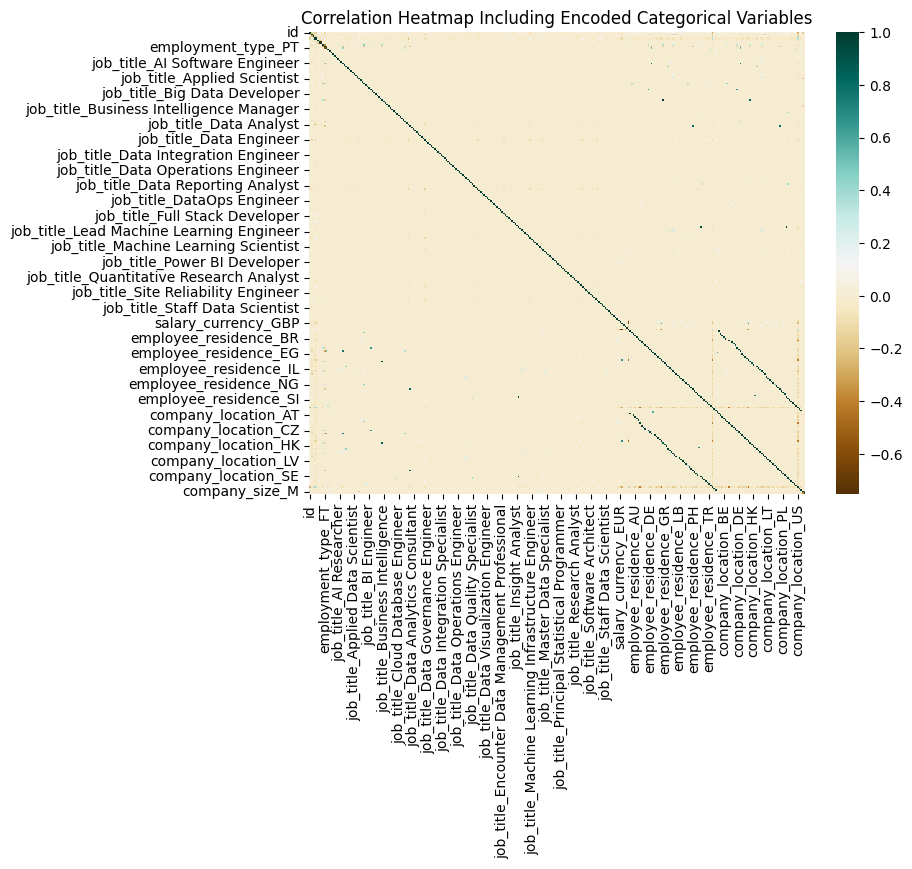

In [157]:
data_encoded = pd.get_dummies(tugas_df, drop_first=True)

correlation_matrix = data_encoded.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='BrBG', fmt=".2f")
plt.title("Correlation Heatmap Including Encoded Categorical Variables")
plt.show()

# Analisis Heatmap:

1. Pada job_title, ada beberapa jabatan yang memiliki korelasi negatif yang kuat satu sama lain. Hal ini menunjukkan bahwa jabatan tertentu cenderung tidak ditemukan di set data yang sama dengan jabatan lainnya. Sebagai contoh, 'AI Developer' dan 'AI Solution Architect'  memiliki korelasi negatif, yang mengindikasikan bahwa keduanya tidak sering dikaitkan dengan titik data yang sama.

2. Ada beberapa korelasi negatif yang lebih lemah antara tempat tinggal karyawan serta lokasi perusahaan. Hal ini  menunjukkan bahwa negara atau wilayah tertentu memiliki dinamika pasar kerja yang berbeda atau preferensi untuk peran tertentu serta perbedaan regional dalam pasar kerja atau preferensi perusahaan.

3. Tantangan dalam menginterpretasikan peta panas ini terletak pada sifat variabel kategorikal yang dikodekan. Peta panas menunjukkan korelasi antara nilai-nilai yang dikodekan ini, yang mungkin tidak secara langsung diterjemahkan ke dalam hubungan yang berarti antara variabel kategorikal asli.


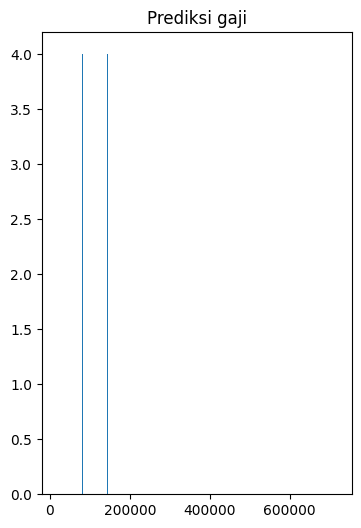

In [158]:
plt.figure(figsize=(4, 6))
plt.bar(tugas_df['salary'], tugas_df['work_year'])
plt.title('Prediksi gaji')
plt.show()

# Analisis Grafik Prediksi Gaji:

Data sangat terkonsentrasi pada kisaran gaji yang lebih rendah, khususnya di bawah 200.000. Tidak ada titik data yang signifikan di atas 200.000. Ini mengindikasikan adanya  distribusi yang tidak biasa.


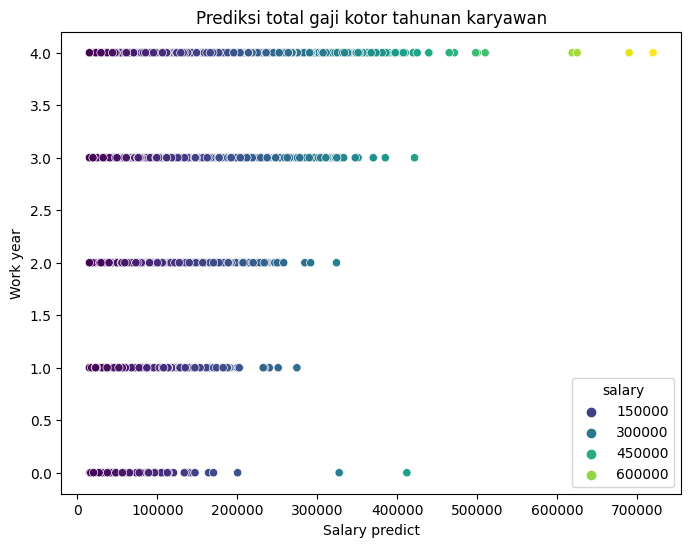

In [159]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = tugas_df['salary'], y = tugas_df['work_year'], hue = tugas_df['salary'], data=tugas_df, palette='viridis')

plt.xlabel("Salary predict")
plt.ylabel("Work year")
plt.title("Prediksi total gaji kotor tahunan karyawan")

plt.show()

# Analisis Grafik Prediksi Total Gaji Kotor Tahunan Karyawan:

1. Distribusi Gaji Berdasarkan Tahun Kerja:
 
 - Tahun kerja 0-1: Sebagian besar karyawan mendapatkan gaji yang lebih rendah (warna biru tua, sekitar 150.000 hingga 300.000).
 
 - Tahun kerja 2-3: Terjadi peningkatan gaji, dengan lebih banyak karyawan dalam rentang gaji 300.000 hingga 450.000.
 
 - Tahun kerja 4 ke atas: Mayoritas gaji karyawan berada pada rentang yang lebih tinggi (450.000 hingga 600.000), dengan beberapa karyawan di atas 600.000.

2. Semakin lama seseorang bekerja, semakin tinggi prediksi gaji kotor tahunan mereka, yang menunjukkan adanya korelasi positif antara jumlah tahun kerja dan kenaikan gaji. Pada tahun kerja yang lebih rendah (0-2 tahun), terlihat data yang lebih padat di kategori gaji rendah, yang menunjukkan jumlah karyawan lebih banyak pada rentang awal karier. Tahun kerja 3 ke atas memiliki distribusi lebih tersebar dengan gaji yang lebih tinggi.

3. Karyawan dengan pengalaman lebih lama (tahun kerja yang lebih tinggi) cenderung memperoleh gaji yang lebih tinggi, mencerminkan nilai pengalaman dalam organisasi. Untuk meningkatkan retensi karyawan jangka panjang, perusahaan dapat mempertimbangkan peningkatan gaji yang kompetitif seiring bertambahnya tahun kerja.

# Correlation Heatmap

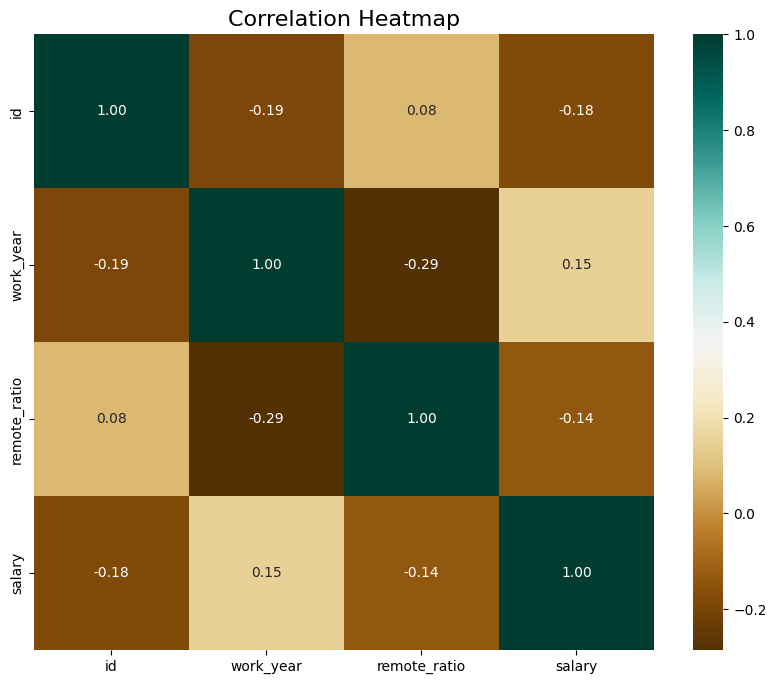

In [160]:
some_columns = ['id','work_year','remote_ratio', 'salary']
correlation_matrix = tugas_df[some_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='BrBG', cbar=True)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

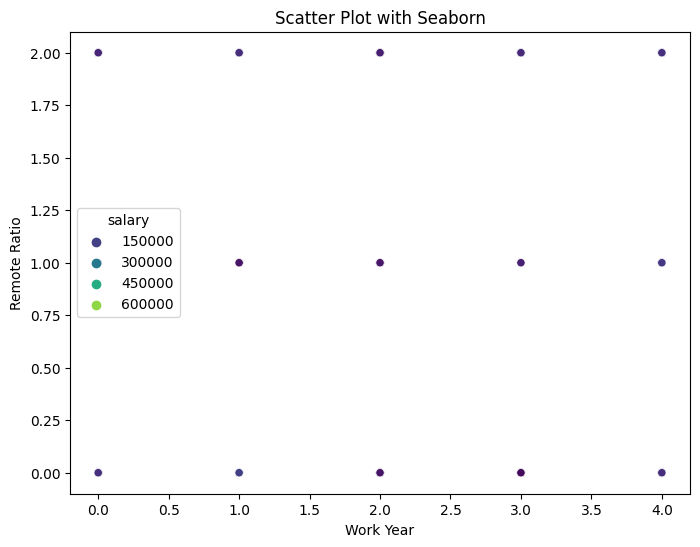

In [161]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = tugas_df['work_year'], y = tugas_df['remote_ratio'], hue = tugas_df['salary'], data=tugas_df, palette='viridis')

plt.xlabel("Work Year")
plt.ylabel("Remote Ratio")
plt.title("Scatter Plot with Seaborn")

plt.show()

# **Modelling**

In [162]:
features = ['work_year', 'remote_ratio', 'salary', 'salary_currency', 'company_location']
featured_df = tugas_df[features]

X = tugas_df[features]
y = tugas_df['salary']

featured_df

,work_year,remote_ratio,salary,salary_currency,company_location
17,4,0.0,92900,USD,US
18,4,0.0,175000,USD,US
20,4,0.0,500000,USD,US
22,4,0.0,140000,USD,US
23,4,0.0,247600,USD,US
...,...,...,...,...,...
35041,3,2.0,99134,USD,US
35046,4,0.0,129280,USD,US
35048,2,2.0,59202,USD,PL
35053,2,2.0,73035,USD,US


In [222]:
from sklearn.model_selection import train_test_split

X = tugas_df.drop('salary', axis=1)
y = tugas_df['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state =42)

In [223]:
from category_encoders import BinaryEncoder

non_numeric_columns = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']
encoder = BinaryEncoder(cols=non_numeric_columns)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [225]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [166]:
target_encoding_columns = ['categorical_column'] 

for col in target_encoding_columns:
    if col in test_df.columns:
        target_mean = test_df.groupby(col)['salary'].transform('mean')
        test_df[col] = test_df[col].map(target_mean)
    else:
        print(f"Column '{col}' not found in test_df.")

Column 'categorical_column' not found in test_df.


In [167]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols='experience_level',
                          return_df=True,
                          use_cat_names=True)
encoded_cols = encoder.fit_transform(test_df['experience_level'])

target_encoding_columns = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_size']

for col in target_encoding_columns:
    target_mean = test_df.groupby(col)['id'].mean()
    test_df[col] = test_df[col].map(target_mean)
    
test_df.drop(columns=target_encoding_columns, inplace=True)
test_df.head()

,id,work_year,remote_ratio,salary_currency_encoded,company_location_encoded
0,0,2024,0,152183.385119,161421.073995
1,1,2023,0,152183.385119,161421.073995
2,2,2024,0,152183.385119,161421.073995
3,3,2024,0,152183.385119,161421.073995
4,4,2024,0,152183.385119,161421.073995


In [168]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print('Linear Regression Train Score:', lr_model.score(X_train, y_train))
print('Linear Regression Test Score:', lr_model.score(X_test, y_test))

Linear Regression Train Score: 1.0
Linear Regression Test Score: 1.0


In [169]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

rf_model = rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print('Random Forest Train Score:', rf_model.score(X_train, y_train))
print('Random Forest Test Score:', rf_model.score(X_test, y_test))

Random Forest Train Score: 1.0
Random Forest Test Score: 0.14423076923076922


In [170]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=150, learning_rate= 0.168374994352571, max_depth= 5, min_samples_split=10)

gb_model = gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
print('Gradient Boost Train Score:', gb_model.score(X_train, y_train))
print('Gradient Boost Test Score:', gb_model.score(X_test, y_test))

Gradient Boost Train Score: 0.9999941023243889
Gradient Boost Test Score: 0.9999830545980894


In [234]:
from catboost import CatBoostRegressor 
  
model = CatBoostRegressor(loss_function='RMSE') 
model.fit(X_train, y_train, verbose=100) 

Learning rate set to 0.054082
0:	learn: 66083.1932278	total: 3.21ms	remaining: 3.2s
100:	learn: 1348.5766065	total: 302ms	remaining: 2.69s
200:	learn: 831.0166624	total: 589ms	remaining: 2.34s
300:	learn: 632.4229313	total: 890ms	remaining: 2.07s
400:	learn: 501.6414531	total: 1.19s	remaining: 1.78s
500:	learn: 422.9895628	total: 1.5s	remaining: 1.49s
600:	learn: 363.7064754	total: 1.83s	remaining: 1.22s
700:	learn: 316.9613465	total: 2.12s	remaining: 905ms
800:	learn: 278.5164000	total: 2.43s	remaining: 603ms
900:	learn: 249.3641614	total: 2.71s	remaining: 298ms
999:	learn: 224.2467196	total: 2.97s	remaining: 0us


In [236]:
!pip install catboost

In [284]:
from catboost import Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'max_features': None,
    }

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1],
    'iterations': [500, 1000],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 0.5, 1]
}

random_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0), 
    param_distributions=param_grid, 
    n_iter=10,
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", (-random_search.best_score_))

catboostmodel = random_search.best_estimator_
catboostmodel.fit(X_train, y_train)

y_pred = catboostmodel.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test RMSE:", test_rmse)

hasil_prediksi = catboostmodel.fit(X_train, y_train)

Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 6, 'bagging_temperature': 1}
Best RMSE: 1098964.523039714
Test RMSE: 389.77794522202


# **Evaluasi Linear Regression**

In [252]:
#MAE
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, lr_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 1506.4289559588767


In [253]:
#MAPE
mape = mean_absolute_percentage_error(y_test, lr_pred) * 100
print("Mean Absolute Percentage Error:", mape, "%")

Mean Absolute Percentage Error: 0.8125102337732936 %


In [254]:
#MSE
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, rf_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 902395663.5763785


In [255]:
#RMSE

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 30039.90119118867


In [256]:
#VarScore
from sklearn.metrics import explained_variance_score

var_score = explained_variance_score(y_test, rf_pred)
print("Variance Score:", var_score)

Variance Score: 0.8192657359554777


In [257]:
#R-square
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, rf_pred)
print("R-squared:", r_squared)

R-squared: 0.8189699601333087


In [258]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

features_to_scale = ['id', 'work_year', 'remote_ratio']

standard_scaler = StandardScaler()
tugas_df[features_to_scale] = standard_scaler.fit_transform(tugas_df[features_to_scale])

minmax_scaler = MinMaxScaler()
tugas_df[features_to_scale] = minmax_scaler.fit_transform(tugas_df[features_to_scale])

robust_scaler = RobustScaler()
tugas_df[features_to_scale] = robust_scaler.fit_transform(tugas_df[features_to_scale])

print(tugas_df[features_to_scale])

             id  work_year  remote_ratio
17    -0.962804       0.00           0.0
18    -0.962718       0.00           0.0
20    -0.962631       0.00           0.0
22    -0.962501       0.00           0.0
23    -0.962414       0.00           0.0
...         ...        ...           ...
35041  1.198926      -0.25           1.0
35046  1.199229       0.00           0.0
35048  1.199316      -0.50           1.0
35053  1.199576      -0.50           1.0
35070  1.200831       0.00           0.0

[7277 rows x 3 columns]


# **Evaluasi Model**

In [259]:
Q1 = tugas_df['salary'].quantile(0.25)
Q3 = tugas_df['salary'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

tugas_df_no_outliers = tugas_df[(tugas_df['salary'] >= lower_bound) & (tugas_df['salary'] <= upper_bound)]

tugas_df['salary'] = tugas_df['salary'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

In [260]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(abs))
])
X = tugas_df.drop('salary', axis=1)
y = tugas_df['salary']

In [261]:
from sklearn.metrics import mean_squared_error, r2_score

r3 = r2_score(y_test, lr_pred)
mae3 = mean_absolute_error(y_test, lr_pred)
mse = mean_squared_error(y_test, lr_pred)
rmse = np.sqrt(mse)

print(f'R2 : {r3}')
print(f'(MAE): {mae3}')
print(f'(MSE): {mse}')
print(f'(RMSE): {rmse}')

R2 : 0.96793258348678
(MAE): 1506.4289559588767
(MSE): 159849147.82616505
(RMSE): 12643.14627876167


In [183]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    
    model = GradientBoostingRegressor(n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    return mean_squared_error(y_test, y_pred)

In [262]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('model', GradientBoostingRegressor(n_estimators=100))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [263]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  

[I 2024-11-17 14:55:21,921] A new study created in memory with name: no-name-a2f81b7f-6807-4bbf-a9f2-dd8d2d469740
[I 2024-11-17 14:55:25,672] Trial 0 finished with value: 254080.15635917056 and parameters: {'n_estimators': 200, 'learning_rate': 0.2709618855506166, 'max_depth': 7, 'min_samples_split': 2}. Best is trial 0 with value: 254080.15635917056.
[I 2024-11-17 14:55:27,710] Trial 1 finished with value: 2080895.1548310493 and parameters: {'n_estimators': 109, 'learning_rate': 0.03514163520728304, 'max_depth': 7, 'min_samples_split': 2}. Best is trial 0 with value: 254080.15635917056.
[I 2024-11-17 14:55:29,022] Trial 2 finished with value: 255119.10066903778 and parameters: {'n_estimators': 62, 'learning_rate': 0.2918446454230296, 'max_depth': 8, 'min_samples_split': 8}. Best is trial 0 with value: 254080.15635917056.
[I 2024-11-17 14:55:31,034] Trial 3 finished with value: 258582.62367178206 and parameters: {'n_estimators': 109, 'learning_rate': 0.07552110848169065, 'max_depth': 7

In [264]:
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 254080.15635917056
  Params:
    n_estimators: 200
    learning_rate: 0.2709618855506166
    max_depth: 7
    min_samples_split: 2


In [265]:
worst_trial = min(study.trials, key=lambda t: t.value)

print("\nWorst trial:")
print(f"  Value: {worst_trial.value}")
print("  Params:")
for key, value in worst_trial.params.items():
    print(f"    {key}: {value}")


Worst trial:
  Value: 254080.15635917056
  Params:
    n_estimators: 200
    learning_rate: 0.2709618855506166
    max_depth: 7
    min_samples_split: 2


# **Save Prediction**

In [285]:
tugas_df_buat_submisi = pd.read_csv("/kaggle/input/penugasan-oprec-dsai-2024/Test.csv")
encoder = BinaryEncoder(cols=non_numeric_columns)
tugas_df_buat_submisi = encoder.fit_transform(tugas_df_buat_submisi)

In [288]:
submission_df = pd.DataFrame({'id': tugas_df_buat_submisi['id']})
submission_df['salary'] = hasil_prediksi

submission_df.to_csv('submission.csv', index=False)